In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/san-francisco-crime-classification/test.csv
/kaggle/input/san-francisco-crime-classification/train.csv


In [72]:
from plotly.offline import plot
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [75]:
data = pd.read_csv('/kaggle/input/san-francisco-crime-classification/train.csv')
data_test = pd.read_csv('/kaggle/input/san-francisco-crime-classification/test.csv')
data_test.head()

Id                Dates DayOfWeek PdDistrict                   Address  \
0   0  2015-05-10 23:59:00    Sunday    BAYVIEW   2000 Block of THOMAS AV   
1   1  2015-05-10 23:51:00    Sunday    BAYVIEW        3RD ST / REVERE AV   
2   2  2015-05-10 23:50:00    Sunday   NORTHERN    2000 Block of GOUGH ST   
3   3  2015-05-10 23:45:00    Sunday  INGLESIDE  4700 Block of MISSION ST   
4   4  2015-05-10 23:45:00    Sunday  INGLESIDE  4700 Block of MISSION ST   

            X          Y  
0 -122.399588  37.735051  
1 -122.391523  37.732432  
2 -122.426002  37.792212  
3 -122.437394  37.721412  
4 -122.437394  37.721412

In [4]:
data.head()

Dates        Category                      Descript  \
0  2015-05-13 23:53:00        WARRANTS                WARRANT ARREST   
1  2015-05-13 23:53:00  OTHER OFFENSES      TRAFFIC VIOLATION ARREST   
2  2015-05-13 23:33:00  OTHER OFFENSES      TRAFFIC VIOLATION ARREST   
3  2015-05-13 23:30:00   LARCENY/THEFT  GRAND THEFT FROM LOCKED AUTO   
4  2015-05-13 23:30:00   LARCENY/THEFT  GRAND THEFT FROM LOCKED AUTO   

   DayOfWeek PdDistrict      Resolution                    Address  \
0  Wednesday   NORTHERN  ARREST, BOOKED         OAK ST / LAGUNA ST   
1  Wednesday   NORTHERN  ARREST, BOOKED         OAK ST / LAGUNA ST   
2  Wednesday   NORTHERN  ARREST, BOOKED  VANNESS AV / GREENWICH ST   
3  Wednesday   NORTHERN            NONE   1500 Block of LOMBARD ST   
4  Wednesday       PARK            NONE  100 Block of BRODERICK ST   

            X          Y  
0 -122.425892  37.774599  
1 -122.425892  37.774599  
2 -122.424363  37.800414  
3 -122.426995  37.800873  
4 -122.438738  37.771541

In [76]:
data['Dates'] = pd.to_datetime(data['Dates'])
data['Date'] = [d.date() for d in data['Dates']]
data['Time'] = [d.time() for d in data['Dates']]

In [6]:
data.dtypes

Dates         datetime64[ns]
Category              object
Descript              object
DayOfWeek             object
PdDistrict            object
Resolution            object
Address               object
X                    float64
Y                    float64
Date                  object
Time                  object
dtype: object

In [7]:
data.groupby(['Category'])['Category'].count().sort_values()

Category
TREA                                6
PORNOGRAPHY/OBSCENE MAT            22
GAMBLING                          146
SEX OFFENSES NON FORCIBLE         148
EXTORTION                         256
BRIBERY                           289
BAD CHECKS                        406
FAMILY OFFENSES                   491
SUICIDE                           508
EMBEZZLEMENT                     1166
LOITERING                        1225
ARSON                            1513
LIQUOR LAWS                      1903
RUNAWAY                          1946
DRIVING UNDER THE INFLUENCE      2268
KIDNAPPING                       2341
RECOVERED VEHICLE                3138
DRUNKENNESS                      4280
DISORDERLY CONDUCT               4320
SEX OFFENSES FORCIBLE            4388
STOLEN PROPERTY                  4540
TRESPASS                         7326
PROSTITUTION                     7484
WEAPON LAWS                      8555
SECONDARY CODES                  9985
FORGERY/COUNTERFEITING          10609
FRA

In [77]:
data['hour'] = [d.hour for d in data['Time']]
data.groupby('hour')['hour'].count().sort_values(ascending=False)

hour
18    55104
17    53553
12    51934
16    50137
19    49475
15    48058
22    45741
0     44865
20    44694
14    44424
21    43661
13    43145
23    42460
11    38373
10    37806
9     35555
8     32900
1     26173
2     22296
7     22048
3     14014
6     13133
4      9863
5      8637
Name: hour, dtype: int64

In [9]:
data.groupby('DayOfWeek')['DayOfWeek'].count().sort_values(ascending=False)

DayOfWeek
Friday       133734
Wednesday    129211
Saturday     126810
Thursday     125038
Tuesday      124965
Monday       121584
Sunday       116707
Name: DayOfWeek, dtype: int64

In [78]:
data['year'] = [d.year for d in data['Date']]
data.groupby('year')['year'].count().sort_values(ascending=False)

year
2013    75606
2014    74766
2003    73902
2004    73422
2012    71731
2005    70779
2008    70174
2006    69909
2009    69000
2007    68015
2011    66619
2010    66542
2015    27584
Name: year, dtype: int64

In [11]:
data.groupby(['Category','Descript'])['Category'].count()

Category     Descript                                               
ARSON        ARSON                                                      447
             ARSON OF A COMMERCIAL BUILDING                              65
             ARSON OF A POLICE BUILDING                                   2
             ARSON OF A POLICE VEHICLE                                    1
             ARSON OF A VACANT BUILDING                                  33
                                                                       ... 
WEAPON LAWS  WEAPON, DEADLY, CARRYING WITH INTENT TO COMMIT ASSAULT      74
             WEAPON, DEADLY, EXHIBITING TO RESIST ARREST                 28
             WEAPON, POSSESS OR BRING OTHER ON SCHOOL GROUNDS           117
             WEAPON, POSSESSING IN PUBLIC BUILDING OR OPEN MEETING       17
             WEAPON, TAKING OR ATTEMPTING TO TAKE FROM PEACE OFFICER      8
Name: Category, Length: 887, dtype: int64

In [12]:
data.groupby(['Category','Resolution'])['Category'].count()

Category     Resolution                            
ARSON        ARREST, BOOKED                            203
             ARREST, CITED                               7
             CLEARED-CONTACT JUVENILE FOR MORE INFO      1
             COMPLAINANT REFUSES TO PROSECUTE            2
             JUVENILE ADMONISHED                         3
                                                      ... 
WEAPON LAWS  NOT PROSECUTED                             31
             PROSECUTED BY OUTSIDE AGENCY                5
             PROSECUTED FOR LESSER OFFENSE               1
             PSYCHOPATHIC CASE                          11
             UNFOUNDED                                  76
Name: Category, Length: 528, dtype: int64

In [13]:

data.groupby(['PdDistrict','Category'])['Category'].count()



PdDistrict  Category     
BAYVIEW     ARSON             393
            ASSAULT          9857
            BAD CHECKS         34
            BRIBERY            56
            BURGLARY         3930
                             ... 
TENDERLOIN  TRESPASS         1192
            VANDALISM        1616
            VEHICLE THEFT    1006
            WARRANTS         7326
            WEAPON LAWS       794
Name: Category, Length: 382, dtype: int64

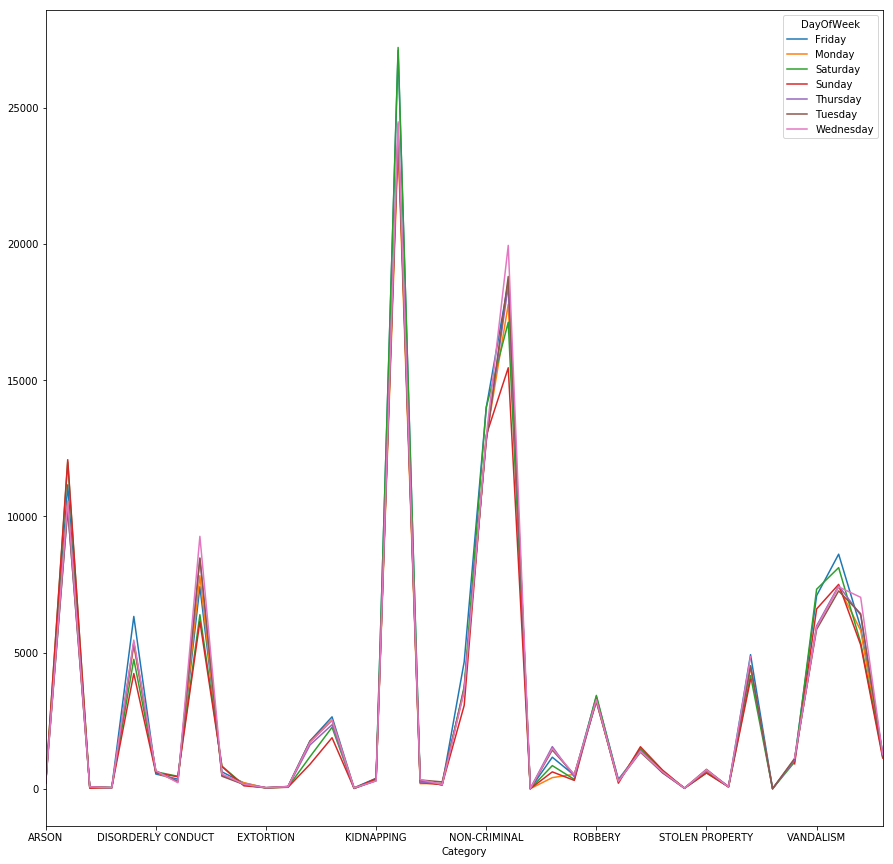

In [79]:
fig, ax = plt.subplots(figsize=(15,15))
#data.groupby(['Category','DayOfWeek']).count().unstack().plot(ax=ax)
data.groupby(['Category','DayOfWeek']).count()['Dates'].unstack().plot(ax=ax)

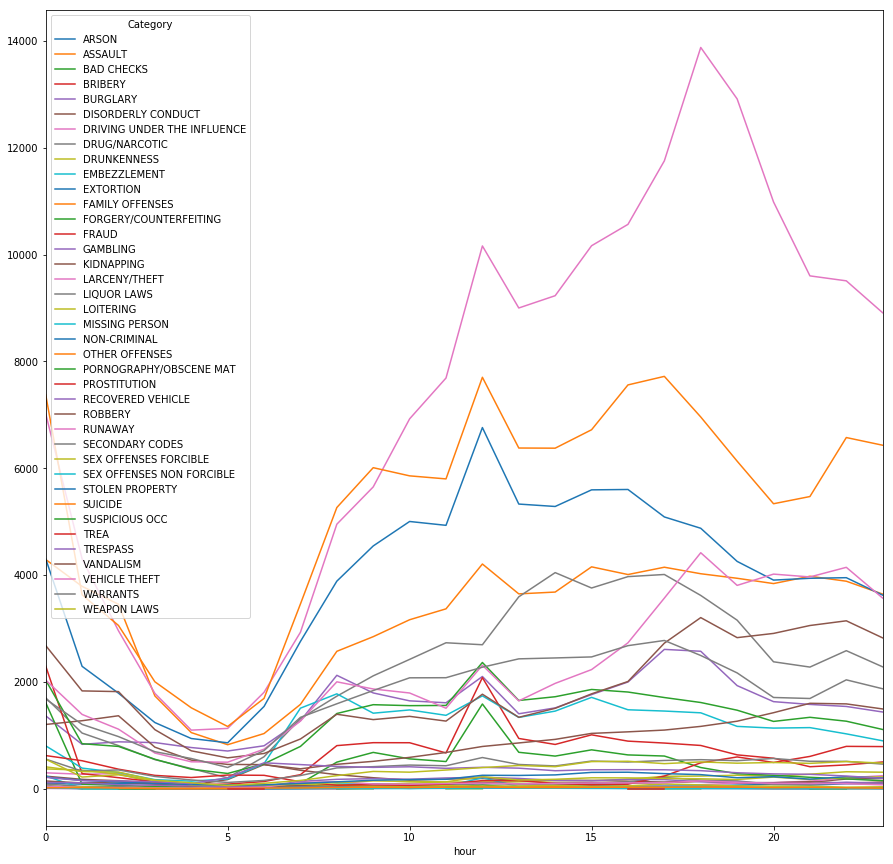

In [35]:
fig, ax = plt.subplots(figsize=(15,15))
data.groupby(['hour','Category']).count()['Dates'].unstack().plot(ax=ax)

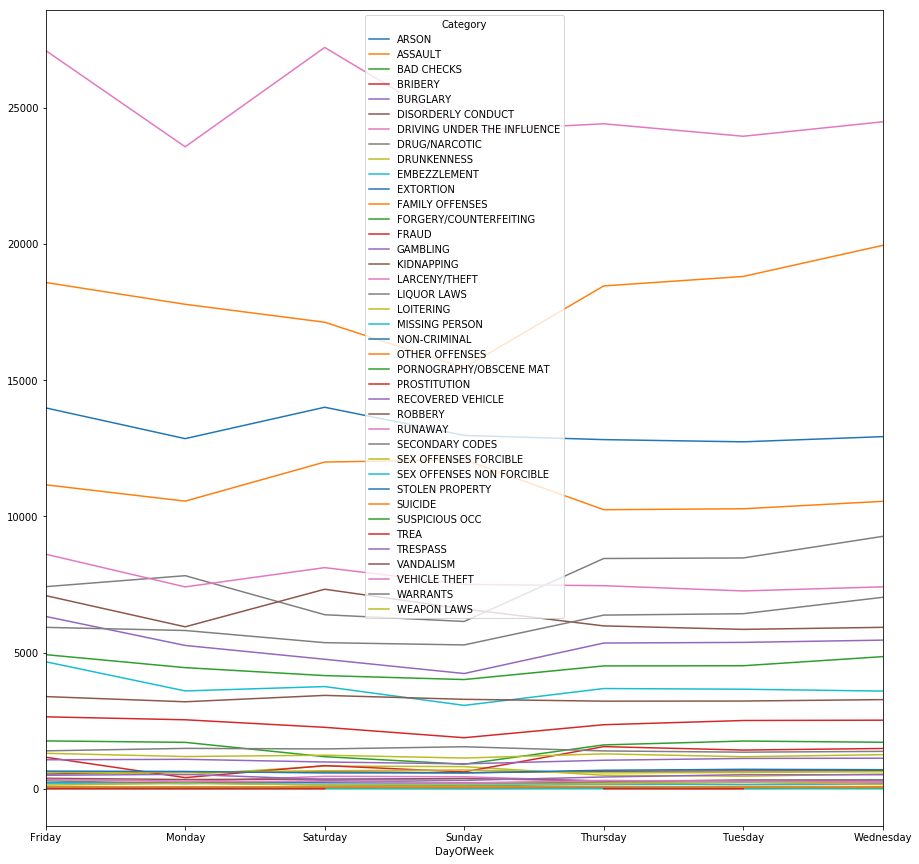

In [36]:
fig, ax = plt.subplots(figsize=(15,15))
data.groupby(['DayOfWeek','Category']).count()['Dates'].unstack().plot(ax=ax)

In [39]:
data.head()

Dates        Category                      Descript  \
0 2015-05-13 23:53:00        WARRANTS                WARRANT ARREST   
1 2015-05-13 23:53:00  OTHER OFFENSES      TRAFFIC VIOLATION ARREST   
2 2015-05-13 23:33:00  OTHER OFFENSES      TRAFFIC VIOLATION ARREST   
3 2015-05-13 23:30:00   LARCENY/THEFT  GRAND THEFT FROM LOCKED AUTO   
4 2015-05-13 23:30:00   LARCENY/THEFT  GRAND THEFT FROM LOCKED AUTO   

   DayOfWeek PdDistrict      Resolution                    Address  \
0  Wednesday   NORTHERN  ARREST, BOOKED         OAK ST / LAGUNA ST   
1  Wednesday   NORTHERN  ARREST, BOOKED         OAK ST / LAGUNA ST   
2  Wednesday   NORTHERN  ARREST, BOOKED  VANNESS AV / GREENWICH ST   
3  Wednesday   NORTHERN            NONE   1500 Block of LOMBARD ST   
4  Wednesday       PARK            NONE  100 Block of BRODERICK ST   

            X          Y        Date      Time  hour  year  month  dayOfMonth  \
0 -122.425892  37.774599  2015-05-13  23:53:00    23  2015      5          13   
1 -122.425892  37.774599  2015-05-13  23:53:00    23  2015      5          13   
2 -122.424363  37.800414  2015-05-13  23:33:00    23  2015      5          13   
3 -122.426995  37.800873  2015-05-13  23:30:00    23  2015      5          13   
4 -122.438738  37.771541  2015-05-13  23:30:00    23  2015      5          13   

   minute  
0      53  
1      53  
2      33  
3      30  
4      30

In [80]:
data['month'] = [d.month for d in data['Date']]
data['dayOfMonth'] = [d.day for d in data['Date']]
data['minute'] = [d.minute for d in data['Time']]
data_d = data.drop(['Dates', 'Descript','Resolution','Address','Date','Time'], axis=1)

In [81]:
data_d.head()

Category  DayOfWeek PdDistrict           X          Y  hour  year  \
0        WARRANTS  Wednesday   NORTHERN -122.425892  37.774599    23  2015   
1  OTHER OFFENSES  Wednesday   NORTHERN -122.425892  37.774599    23  2015   
2  OTHER OFFENSES  Wednesday   NORTHERN -122.424363  37.800414    23  2015   
3   LARCENY/THEFT  Wednesday   NORTHERN -122.426995  37.800873    23  2015   
4   LARCENY/THEFT  Wednesday       PARK -122.438738  37.771541    23  2015   

   month  dayOfMonth  minute  
0      5          13      53  
1      5          13      53  
2      5          13      33  
3      5          13      30  
4      5          13      30

In [132]:
y = data['Category']
le = preprocessing.LabelEncoder()
z = le.fit(y)
y = le.transform(y)



In [85]:
data_d.drop(['Category'], axis=1, inplace=True)

In [86]:
numerical = data_d.select_dtypes(exclude=['object'])
cat_vars = data_d.select_dtypes(include=['object'])
cat_vars

DayOfWeek PdDistrict
0       Wednesday   NORTHERN
1       Wednesday   NORTHERN
2       Wednesday   NORTHERN
3       Wednesday   NORTHERN
4       Wednesday       PARK
...           ...        ...
878044     Monday    TARAVAL
878045     Monday  INGLESIDE
878046     Monday   SOUTHERN
878047     Monday   SOUTHERN
878048     Monday    BAYVIEW

[878049 rows x 2 columns]

In [87]:
cat_one_hot = pd.get_dummies(cat_vars)
cat_one_hot.head()


DayOfWeek_Friday  DayOfWeek_Monday  DayOfWeek_Saturday  DayOfWeek_Sunday  \
0                 0                 0                   0                 0   
1                 0                 0                   0                 0   
2                 0                 0                   0                 0   
3                 0                 0                   0                 0   
4                 0                 0                   0                 0   

   DayOfWeek_Thursday  DayOfWeek_Tuesday  DayOfWeek_Wednesday  \
0                   0                  0                    1   
1                   0                  0                    1   
2                   0                  0                    1   
3                   0                  0                    1   
4                   0                  0                    1   

   PdDistrict_BAYVIEW  PdDistrict_CENTRAL  PdDistrict_INGLESIDE  \
0                   0                   0                     0   
1                   0                   0                     0   
2                   0                   0                     0   
3                   0                   0                     0   
4                   0                   0                     0   

   PdDistrict_MISSION  PdDistrict_NORTHERN  PdDistrict_PARK  \
0                   0                    1                0   
1                   0                    1                0   
2                   0                    1                0   
3                   0                    1                0   
4                   0                    0                1   

   PdDistrict_RICHMOND  PdDistrict_SOUTHERN  PdDistrict_TARAVAL  \
0                    0                    0                   0   
1                    0                    0                   0   
2                    0                    0                   0   
3                    0                    0                   0   
4                    0                    0                   0   

   PdDistrict_TENDERLOIN  
0                      0  
1                      0  
2                      0  
3                      0  
4                      0

In [88]:
X = pd.concat([numerical, cat_one_hot], axis=1)
X.head()

X          Y  hour  year  month  dayOfMonth  minute  \
0 -122.425892  37.774599    23  2015      5          13      53   
1 -122.425892  37.774599    23  2015      5          13      53   
2 -122.424363  37.800414    23  2015      5          13      33   
3 -122.426995  37.800873    23  2015      5          13      30   
4 -122.438738  37.771541    23  2015      5          13      30   

   DayOfWeek_Friday  DayOfWeek_Monday  DayOfWeek_Saturday  ...  \
0                 0                 0                   0  ...   
1                 0                 0                   0  ...   
2                 0                 0                   0  ...   
3                 0                 0                   0  ...   
4                 0                 0                   0  ...   

   PdDistrict_BAYVIEW  PdDistrict_CENTRAL  PdDistrict_INGLESIDE  \
0                   0                   0                     0   
1                   0                   0                     0   
2                   0                   0                     0   
3                   0                   0                     0   
4                   0                   0                     0   

   PdDistrict_MISSION  PdDistrict_NORTHERN  PdDistrict_PARK  \
0                   0                    1                0   
1                   0                    1                0   
2                   0                    1                0   
3                   0                    1                0   
4                   0                    0                1   

   PdDistrict_RICHMOND  PdDistrict_SOUTHERN  PdDistrict_TARAVAL  \
0                    0                    0                   0   
1                    0                    0                   0   
2                    0                    0                   0   
3                    0                    0                   0   
4                    0                    0                   0   

   PdDistrict_TENDERLOIN  
0                      0  
1                      0  
2                      0  
3                      0  
4                      0  

[5 rows x 24 columns]

In [134]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [137]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [123]:
param = {
    'max_depth': 3,  # the maximum depth of each tree
    'eta': 0.3,  # the training step for each iteration
    'silent': 1,  # logging mode - quiet
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'eval_metric': 'logloss',
    'num_class': 39}  # the number of classes that exist in this datset
num_round = 20  # the number of training iterations

In [138]:
bst = xgb.train(param, dtrain, num_round)

In [139]:
pred_y_test = bst.predict(dtest)

In [140]:
from sklearn.metrics import log_loss
log_loss(y_test,pred_y_test)

2.4420247129371733

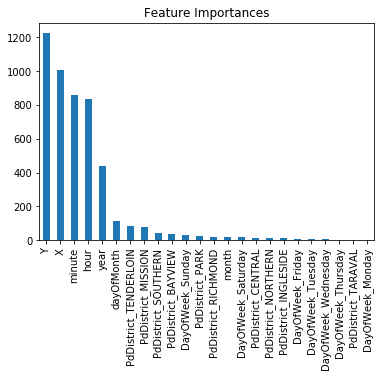

In [130]:
feat_imp = pd.Series(bst.get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')

In [131]:
bst.eval_set()

TypeError: eval_set() missing 1 required positional argument: 'evals'